## PS1

1. Leverage less than 1 basicallly means that we are not investing our entire capital but keeping some part of it ie if we have 10000 and only invest 8000 then we are taking a leverage of 0.8 and keeping the other 2000 with us. Usually it does not take sense to take less than 1 leverage as we are just leaving returns on the table by using less capital and thus getting less returns. Although in our backtesting engine it can make sense if we are not very confident in a trade then we can reduce the amount we invest by tking leverage<1. Another way could be to assign a confidence score at each point in time and put different percentages of our capital thus taking leverage<1.



2. Static stop loss is a constant set at the entry and does not move with the price movement of the stock while a trailing stop moves with the actual price movement of the stock which helps in maximising gain for essentially the same amount of risk (if same values are assigned at the start). In trending markets, a trailing stop loss would be better as it rides the trend and adjusts accordingly which helps maximising gain where a static stop loss mmight be triggered too early due to initial pullback or too late after trend reversion essentially making a loss. In volatile market both are not very effective as they may keep getting triggered due to spikes or due to sideways movement incurring amny small losses.

3. Implemeting a trailing take profit is not necessary as it is essentially completely captured by a trailing stop loss and does not provide any meaning. It also adjusts itself based on price movement same as trailing stop loss and its upsides are captured by trailing stop loss.


4. The main reason for a trade remaining open even after the price has fallen below the set stop-loss comes from low liquidity. One case is where it is set as a limit order where if there is a large gap around stop loss it might not trade and the order may remain open. Another situation is in low-liquidity stocks where you may not find a buyer willing to buy that stock. Another situation is from overnight holds where the next day price may be below the stop loss leaving the trade open.

# PS2

## Importing

In [5]:
!pip install ta

In [6]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from ta.volatility import average_true_range
import matplotlib.dates as mdates

## Data Download

In [7]:
df= yf.download('IDEA.NS',start='2020-06-01',end='2025-06-01',auto_adjust=False)
df.columns = [col[0] for col in df.columns]
df

[*********************100%***********************]  1 of 1 completed


,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2020-06-01,6.55,6.55,6.90,6.00,6.45,504566767
2020-06-02,7.70,7.70,7.85,6.60,6.65,940712269
2020-06-03,8.10,8.10,8.85,7.80,8.00,963452004
2020-06-04,8.60,8.60,8.90,8.00,8.20,870345865
2020-06-05,10.50,10.50,10.75,9.00,9.20,722961400
...,...,...,...,...,...,...
2025-05-26,6.93,6.93,7.05,6.73,6.76,591848002
2025-05-27,6.96,6.96,7.05,6.85,6.86,427262827
2025-05-28,7.12,7.12,7.24,6.96,6.96,611800851


## Identification of candlesticks

In [8]:
def doji(df):
  arr=[]
  for i in range(df.shape[0]):
    close=df.iloc[i].Close
    open=df.iloc[i].Open
    high=df.iloc[i].High
    low=df.iloc[i].Low

    if abs(close-open)<0.1*abs(high-low):
      arr.append(i)

  return np.array(arr)

In [9]:
def hammer(df):
  arr=[]
  for i in range(df.shape[0]):

    close=df.iloc[i].Close
    open=df.iloc[i].Open
    high=df.iloc[i].High
    low=df.iloc[i].Low

    body = abs(close - open)
    upper_shadow = high - max(close, open)
    lower_shadow = min(close, open) - low
    candle_length = high - low

    if (body/candle_length<0.3 and lower_shadow>2*body and upper_shadow<body):
        arr.append(i)

  return np.array(arr)

In [10]:
def bullish_engulfing(df):
  arr=[]
  for i in range(1,df.shape[0]):
    prev_close=df.iloc[i-1].Close
    prev_open=df.iloc[i-1].Open
    curr_close=df.iloc[i].Close
    curr_open=df.iloc[i].Open

    if (prev_close < prev_open and curr_close > curr_open and curr_open < prev_close and curr_close > prev_open):
      prev_body = abs(prev_open - prev_close)
      curr_body = abs(curr_close - curr_open)

      arr.append(i)

  return np.array(arr)

In [11]:
def bearish_engulfing(df):
  arr=[]
  for i in range(1,df.shape[0]):
    prev_close=df.iloc[i-1].Close
    prev_open=df.iloc[i-1].Open
    curr_close=df.iloc[i].Close
    curr_open=df.iloc[i].Open

    if (prev_close > prev_open and curr_close < curr_open and curr_open > prev_close and curr_close < prev_open):
      arr.append(i)

  return np.array(arr)

## Calculatinng Win Rate for all candles

In [12]:
def win_rate(df,arr,candlestick_type,look_ahead):

  lookahead_arr=arr+look_ahead

  if candlestick_type=='doji':
    wins=0
    # Ensure lookahead indices are within bounds
    valid_indices=lookahead_arr < df.shape[0]
    arr=arr[valid_indices]
    lookahead_arr=lookahead_arr[valid_indices]

    entry=np.array(df.iloc[arr]['Close'])
    exit=np.array(df.iloc[lookahead_arr]['Close'])
    change=exit-entry

    # Ensure previous day indices are within bounds
    valid_prev_indices=arr-1>=0
    arr_prev=arr[valid_prev_indices]
    arr_curr=arr[valid_prev_indices]

    diff=np.array(df.iloc[arr_prev]['Close']-df.iloc[arr_prev]['Open']).reshape(1,-1)[0]

    trend=np.zeros(len(arr_curr))
    trend[diff>0]=1

    for i in range(len(arr_curr)):
      if change[i]>0 and trend[i] == 0: # Bearish trend before doji, price went up after
          wins+=1
      elif change[i] < 0 and trend[i] == 1: # Bullish trend before doji, price went down after
          wins+=1

    return wins*100/len(arr)

  elif candlestick_type=='hammer':
    wins=0
    # Ensure lookahead indices are within bounds
    valid_indices=lookahead_arr < df.shape[0]
    arr=arr[valid_indices]
    lookahead_arr=lookahead_arr[valid_indices]

    entry=np.array(df.iloc[arr]['Close'])
    exit=np.array(df.iloc[lookahead_arr]['Close'])
    change=exit-entry

    wins=np.sum(change > 0) #W in if price increases

    return wins*100/len(arr)

  elif candlestick_type=='bullish_engulfing':
      wins=0
      # Ensure lookahead indices are within bounds
      valid_indices=lookahead_arr<df.shape[0]
      arr=arr[valid_indices]
      lookahead_arr=lookahead_arr[valid_indices]

      entry=np.array(df.iloc[arr]['Close'])
      exit=np.array(df.iloc[lookahead_arr]['Close'])
      change=exit - entry

      wins=np.sum(change>0) # Win if price increases

      return wins*100/len(arr)

  elif candlestick_type=='bearish_engulfing':
      wins=0
      # Ensure lookahead indices are within bounds
      valid_indices=lookahead_arr<df.shape[0]
      arr=arr[valid_indices]
      lookahead_arr=lookahead_arr[valid_indices]

      entry=np.array(df.iloc[arr]['Close'])
      exit=np.array(df.iloc[lookahead_arr]['Close'])
      change=exit - entry

      wins=np.sum(change<0) # Win if price increases

      return wins*100/len(arr)

## Baseline Win Rates

In [13]:
def baseline_win_rate(df,M,look_ahead):
  indices=np.random.randint(0,df.shape[0]-look_ahead,M) #Raandom Candles

  look_ahead_arr=indices+look_ahead
  entry=np.array(df.iloc[indices]['Close'])
  exit=np.array(df.iloc[look_ahead_arr]['Close'])
  change=exit-entry # Win if price increases

  return np.sum(change>0)*100/M

In [14]:
doji_arr=doji(df)
hammer_arr=hammer(df)
bullish_engulfing_arr=bullish_engulfing(df)
bearish_engulfing_arr=bearish_engulfing(df)

look_ahead=3

win_rate_doji=win_rate(df,doji_arr,'doji',look_ahead)
win_rate_hammer=win_rate(df,hammer_arr,'hammer',look_ahead)
win_rate_bullish_engulfing=win_rate(df,bullish_engulfing_arr,'bullish_engulfing',look_ahead)
win_rate_bearish_engulfing=win_rate(df,bearish_engulfing_arr,'bearish_engulfing',look_ahead)

engulfing_win_rate=(win_rate_bearish_engulfing+win_rate_bullish_engulfing)/2 #Engufing win-rate is taken as the average of bullish and bearish engulfing win-rates

M=len(doji_arr)+len(hammer_arr)+len(bullish_engulfing_arr)+len(bearish_engulfing_arr)
baseline_winrate=baseline_win_rate(df,M,look_ahead) #Baseline

<ipython-input-9-2736988975>:15: RuntimeWarning: invalid value encountered in scalar divide
  if (body/candle_length<0.3 and lower_shadow>2*body and upper_shadow<body):


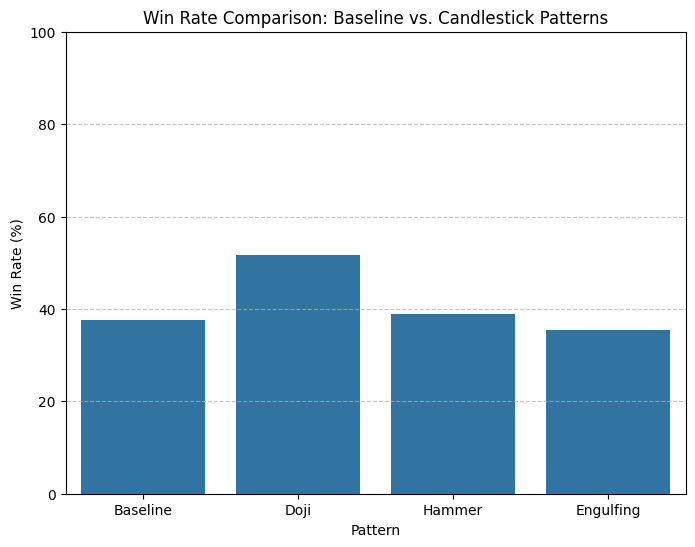

In [15]:
data = {'Pattern': ['Baseline', 'Doji', 'Hammer', 'Engulfing'],
        'Win Rate (%)': [baseline_winrate, win_rate_doji, win_rate_hammer, engulfing_win_rate]}
plot_df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(8, 6))
sns.barplot(x='Pattern', y='Win Rate (%)', data=plot_df)
plt.title('Win Rate Comparison: Baseline vs. Candlestick Patterns')
plt.ylabel('Win Rate (%)')
plt.xlabel('Pattern')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

1. Out of the given patterns for this particular stock, only doji provides a significant edge over the baseline with hammer being almost the same as baseline or being slightly better than the baseline, over all the stocks I tested hammer and doji seemed to be the most consistent performers which actuallly gave an edge while the engulfing did not perform well.

2. Win rates essentially decrease with increase in n as we are looking at short term patterns and trends which are prone to reversal after a short amount of time so increasing n generally gives poorer win rates as the trend might have reversed by that time. Also they may increase slighty with increase in n at the start as it usually takes 1 more candlestick to confirm the trend for the market and drive the trend.

3. In my case doji has shown the most consistent perfomace over all n. One reason for it might be that it is a strong indicator of a trend reversal and the its predictions are less susceptible to noise as it may be the case for other indicators whose trends may end in 1-2 days.

# PS3

## Computing the MFI

In [16]:
def compute_mfi(df, window=14):
    typical_price=(df['high'] + df['low'] + df['close']) / 3
    money_flow=typical_price * df['volume']
    positive_flow=[]
    negative_flow=[]

    for i in range(1, len(df)):
        if typical_price.iloc[i]>typical_price.iloc[i-1]:
            positive_flow.append(money_flow.iloc[i])
            negative_flow.append(0)
        elif typical_price.iloc[i] <typical_price.iloc[i-1]:
            positive_flow.append(0)
            negative_flow.append(money_flow.iloc[i])
        else:
            positive_flow.append(0)
            negative_flow.append(0)

    # pad the first row with 0
    positive_flow.insert(0, 0)
    negative_flow.insert(0, 0)

    df['positive_mf']=pd.Series(positive_flow)
    df['negative_mf']=pd.Series(negative_flow)

    positive_mf=df['positive_mf'].rolling(window=window).sum()
    negative_mf=df['negative_mf'].rolling(window=window).sum()

    mfi= 100*(positive_mf/(positive_mf+negative_mf))
    return mfi

## Strategy X
This strategy combines the Supertrend indicator with the Money Flow Index (MFI) to generate buy and sell signals.

A buy signal is triggered when the Supertrend is bullish (supertrend_direction == 1) and the MFI remains above 70 (indicating sustained buying pressure).

A sell signal occurs either when the Supertrend turns bearish or the MFI drops below 40 (indicating a loss of buying momentum).

The strategy maintains a position as long as no sell condition is met.

In [78]:
def strategy_x(df):

    df=df.copy()

    # MFI
    df['mfi']=compute_mfi(df)

    # Supertrend
    df['tr0'] = abs(df['high'] - df['low'])
    df['tr1'] = abs(df['high'] - df['close'].shift())
    df['tr2'] = abs(df['low'] - df['close'].shift())
    df['tr'] = df[['tr0', 'tr1', 'tr2']].max(axis=1)
    df['atr_st'] = df['tr'].rolling(14).mean()

    hl2 = (df['high'] + df['low']) / 2
    multiplier = 3
    df['upperband'] = hl2 + (multiplier * df['atr_st'])
    df['lowerband'] = hl2 - (multiplier * df['atr_st'])

    df['in_uptrend'] = True

    for i in range(1, len(df)):
        if df['close'][i] > df['upperband'][i - 1]:
            df.at[df.index[i], 'in_uptrend'] = True
        elif df['close'][i] < df['lowerband'][i - 1]:
            df.at[df.index[i], 'in_uptrend'] = False
        else:
            df.at[df.index[i], 'in_uptrend'] = df['in_uptrend'][i - 1]
            if df['in_uptrend'][i] and df['lowerband'][i] < df['lowerband'][i - 1]:
                df.at[df.index[i], 'lowerband'] = df['lowerband'][i - 1]
            if not df['in_uptrend'][i] and df['upperband'][i] > df['upperband'][i - 1]:
                df.at[df.index[i], 'upperband'] = df['upperband'][i - 1]

    df['supertrend_direction'] = df['in_uptrend'].astype(int).replace({True: 1, False: -1})

    # Buy Signal
    df['mfi_hold']=(df['mfi'].shift(1)>70) | (df['mfi']>70)
    df['buy']=(df['supertrend_direction']==1) & df['mfi_hold']

    # Sell Signal
    df['mfi_drop']=df['mfi']<40
    df['sell']=(df['supertrend_direction']==-1) | df['mfi_drop']

    df['position']=0
    position=0
    for i in range(len(df)):
        if df['buy'].iloc[i]:
            position=1
        elif df['sell'].iloc[i]:
            position=0
        df.at[df.index[i], 'position']=position

    df['signal']=0
    df.loc[df['buy'],'signal']=1
    df.loc[df['sell'],'signal']=-1

    return df

## Backtesting function
Gives the Total Return, Max Drawdown, Annualised Sharpe Ratio and Win Rate

In [64]:
def backtest_strategy(df,initial_capital=100000):
    df=df.copy()
    df['position']=0

    for i in range(1,len(df)):
        if df['signal'].iloc[i]==1:
            df.loc[df.index[i],'position']=1  # Buy
        elif df['signal'].iloc[i]==-1:
            df.loc[df.index[i],'position']=0  # Sell
        else:
            df.loc[df.index[i],'position']=df['position'].iloc[i-1]  # Hold

    df['returns']=df['close'].pct_change().fillna(0)
    df['strategy_returns']=df['position'].shift(1)*df['returns']

    df['cum_returns']=(1+df['strategy_returns']).cumprod()
    df['cum_market']=(1+df['returns']).cumprod()

    total_return=df['cum_returns'].iloc[-1]-1
    sharpe=df['strategy_returns'].mean()/df['strategy_returns'].std()*np.sqrt(252)
    drawdown=(df['cum_returns']/df['cum_returns'].cummax())-1
    max_dd=drawdown.min()
    win_rate=(df['strategy_returns']>0).mean()

    print(f"Total Return: {total_return:.2%}")
    print(f"Max Drawdown: {max_dd:.2%}")
    print(f"Sharpe Ratio: {sharpe:.2f}")
    print(f"Win Rate: {win_rate:.2%}")

## Function for Plotting

In [59]:
def plot_trading_signals(df, ticker):

    date_col='datetime' if 'datetime' in df.columns else 'Date' if 'Date' in df.columns else df.columns[0]
    df[date_col] = pd.to_datetime(df[date_col])

    fig, ax = plt.subplots(figsize=(14, 7))

    # Plot closing price
    ax.plot(df[date_col], df['close'], label='Close Price', color='blue', linewidth=2)

    # Plot buy signals (green upward triangles)
    buy_signals = df[df['signal'] == 1]
    ax.scatter(buy_signals[date_col], buy_signals['close'], label='Buy Signal',
               marker='^', color='green', s=150, edgecolors='black')

    # Plot sell signals (red downward triangles)
    sell_signals = df[df['signal'] == -1]
    ax.scatter(sell_signals[date_col], sell_signals['close'], label='Sell Signal',
               marker='v', color='red', s=150, edgecolors='black')

    ax.set_title(f'{ticker} Trading Signals', fontsize=16, pad=20)
    ax.set_ylabel('Price (INR)', fontsize=12)
    ax.legend(fontsize=10, loc='upper left')
    ax.grid(True, linestyle='--', alpha=0.5)

    ax.set_xticks([])
    ax.set_xlabel('')

    plt.tight_layout()

    plt.show()

In [71]:
def download_flat_yf(ticker, start, end, interval):
  data = yf.download(ticker, start=start, end=end, interval=interval,
    progress=False)
  if isinstance(data.columns, pd.MultiIndex):
    data = data.xs(ticker, axis=1, level=1)

  data.columns.name = None
  data.reset_index(inplace=True)
  data.columns = [col.lower() for col in data.columns]
  if data.columns[0] in ['date', 'datetime']:
    data.rename(columns={data.columns[0]: 'datetime'}, inplace=True)
  data['datetime'] = pd.to_datetime(data['datetime'])
  return data

stock_symbol = 'CAMS.NS'
data = download_flat_yf(stock_symbol, start='2024-01-04', end='2025-05-04', interval='1d')

Total Return: 48.92%
Max Drawdown: -19.55%
Sharpe Ratio: 1.15
Win Rate: 32.00%


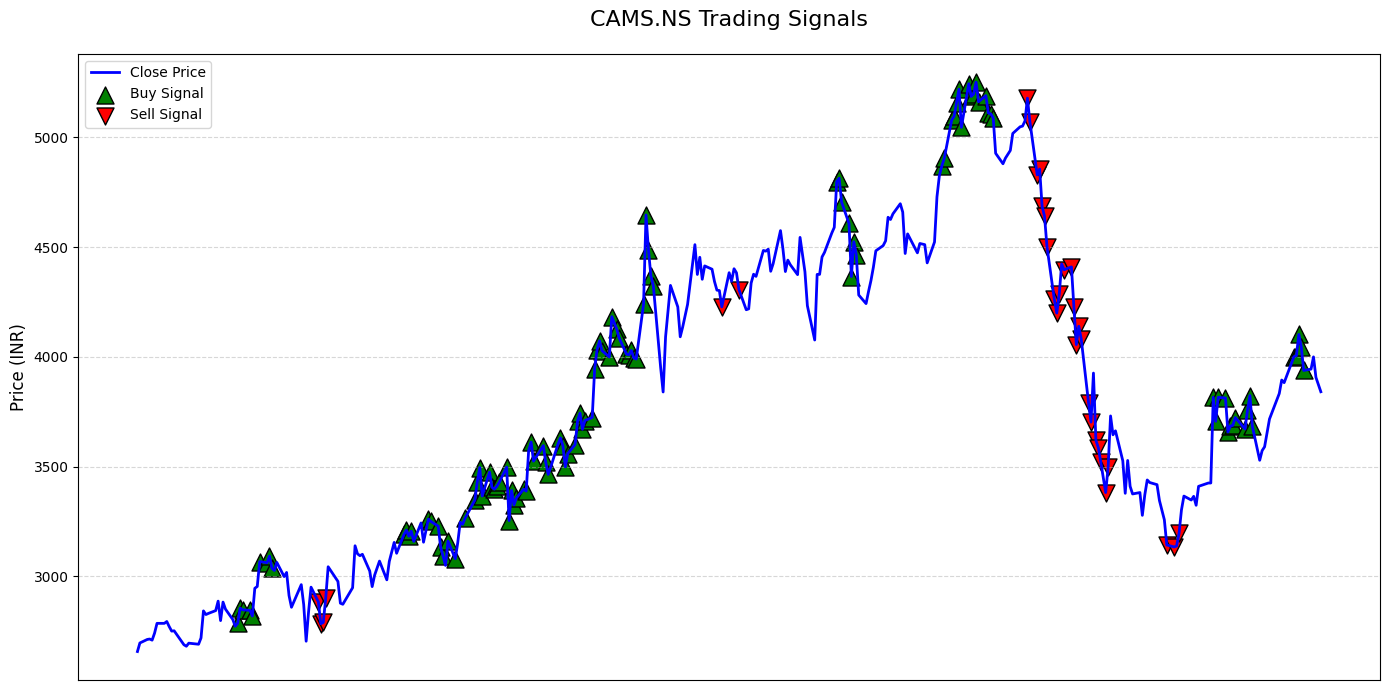

In [79]:
backtest_strategy(strategy_x(data))
plot_trading_signals(strategy_x(data), stock_symbol)

## Strategy Y
Strategy Y builds upon the logic of Strategy X by adding a volatility filter.While Strategy X relied solely on MFI and directional signals from Supertrend, Strategy Y adds a volatility threshold using the Average True Range percentage (ATR%), ensuring trades are only taken during significant market movement.

A buy signal is generated when the Supertrend is bullish or MFI is strong (>70 for two consecutive periods), but only if ATR% exceeds 1.5%, indicating that the market is not in a sideways phase.

Sell signals are triggered if MFI drops below 40 or the Supertrend turns bearish.

This strategy avoids trades in low-volatility conditions, reducing false signals and improving robustness in choppy markets.

In [76]:
def strategy_y(df):
    df = df.copy()

    # --- Compute Money Flow Index (MFI) ---
    df['mfi']=compute_mfi(df)

    # --- Compute ATR and ATR% ---
    df['atr'] = average_true_range(high=df['high'],low=df['low'],close=df['close'],window=14,fillna=False)
    df['atr_pct']=df['atr']/df['close']

    # --- Supertrend ---
    df['tr0'] = abs(df['high'] - df['low'])
    df['tr1'] = abs(df['high'] - df['close'].shift())
    df['tr2'] = abs(df['low'] - df['close'].shift())
    df['tr'] = df[['tr0', 'tr1', 'tr2']].max(axis=1)
    df['atr_st'] = df['tr'].rolling(14).mean()

    hl2 = (df['high'] + df['low']) / 2
    multiplier = 3
    df['upperband'] = hl2 + (multiplier * df['atr_st'])
    df['lowerband'] = hl2 - (multiplier * df['atr_st'])

    df['in_uptrend'] = True

    for i in range(1, len(df)):
        if df['close'][i] > df['upperband'][i - 1]:
            df.at[df.index[i], 'in_uptrend'] = True
        elif df['close'][i] < df['lowerband'][i - 1]:
            df.at[df.index[i], 'in_uptrend'] = False
        else:
            df.at[df.index[i], 'in_uptrend'] = df['in_uptrend'][i - 1]
            if df['in_uptrend'][i] and df['lowerband'][i] < df['lowerband'][i - 1]:
                df.at[df.index[i], 'lowerband'] = df['lowerband'][i - 1]
            if not df['in_uptrend'][i] and df['upperband'][i] > df['upperband'][i - 1]:
                df.at[df.index[i], 'upperband'] = df['upperband'][i - 1]

    df['supertrend_direction'] = df['in_uptrend'].astype(int).replace({True: 1, False: -1})

    # --- Buy Conditions ---
    df['mfi_hold'] = (df['mfi'].shift(1) > 70) & (df['mfi'] > 70)
    df['atr_ok'] = df['atr_pct'] > 0.015  # i.e., ATR% > 1.5%

    df['buy']=(((df['supertrend_direction']==1) | df['mfi_hold']) & df['atr_ok'])

    # --- Sell Conditions ---
    df['mfi_drop']=df['mfi'] < 40
    df['sell']=df['mfi_drop'] | (df['supertrend_direction']==-1)

    # --- Signal Column ---
    df['signal']=0
    df.loc[df['buy'],'signal']=1
    df.loc[df['sell'],'signal']=-1

    # --- Position Tracking ---
    df['position']=0
    pos=0
    for i in range(len(df)):
        if df['signal'].iloc[i]==1:
            pos=1
        elif df['signal'].iloc[i]==-1:
            pos=0
        df.at[df.index[i],'position']=pos

    return df

Total Return: 70.28%
Max Drawdown: -17.36%
Sharpe Ratio: 1.39
Win Rate: 38.15%


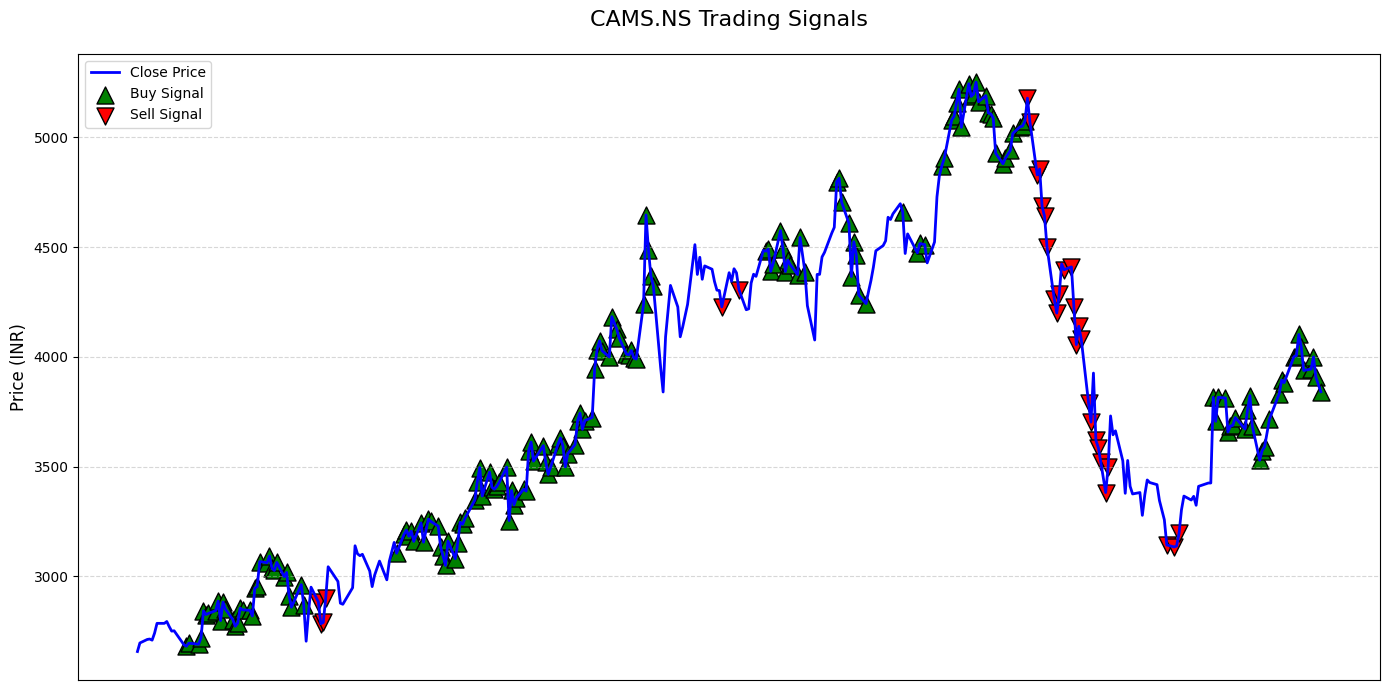

In [77]:
backtest_strategy(strategy_y(data))
plot_trading_signals(strategy_y(data), stock_symbol)

## Strategy Enhancements
The strategy may fail in low-volatility periods as ATR is a lagging indicator and might still be high above threshold for some time after the market calms down. Another problem we currently have is trading in sideways market where we may get many false signals.

Implementing a filter for detecting sideways market may help improve the strategy. Also, using ADX can help filter out weak or sideways trends, allowing trades only when the trend strength is significant.

The low-volatility issue can be solved by using a dynamic threshold instead of a fixed one.